In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os


In [6]:
def load_dataset(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        class_label = 1 if class_name == 'uninfected' else 0
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(class_label)
    return np.array(images), np.array(labels)


In [3]:
# Load and preprocess the data
train_dir = r'C:\Users\OMEN\Malaria_Project\notebook\data\Train'
X, y = load_dataset(train_dir)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Check class distribution
train_infected = np.sum(y_train == 0)
train_uninfected = np.sum(y_train == 1)
val_infected = np.sum(y_val == 0)
val_uninfected = np.sum(y_val == 1)

print(f"Training set - Infected: {train_infected}, Uninfected: {train_uninfected}")
print(f"Validation set - Infected: {val_infected}, Uninfected: {val_uninfected}")


Training set - Infected: 10982, Uninfected: 11064
Validation set - Infected: 2797, Uninfected: 2715


In [19]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (22046, 224, 224, 3)
y_train shape: (22046,)
X_val shape: (5512, 224, 224, 3)
y_val shape: (5512,)


In [2]:

def color_jitter(img):
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    img = tf.image.random_hue(img, max_delta=0.2)
    return img


In [4]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=color_jitter
)

val_datagen = ImageDataGenerator(rescale=1./255)

NameError: name 'ImageDataGenerator' is not defined

In [3]:
val_datagen = ImageDataGenerator(rescale=1./255)

NameError: name 'ImageDataGenerator' is not defined

In [1]:
def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model



In [15]:
# Create and train the model
model = create_model()
model.summary()

c:\Users\OMEN\Malaria_Project\new_venv\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,041 (9.27 MB)

 Trainable params: 172,673 (674.50 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight
)

Epoch 1/50


c:\Users\OMEN\Malaria_Project\new_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


688/688 ━━━━━━━━━━━━━━━━━━━━ 667s 966ms/step - accuracy: 0.4949 - auc_2: 0.4979 - loss: 0.6956 - val_accuracy: 0.4933 - val_auc_2: 0.5007 - val_loss: 264.1949 - learning_rate: 2.0000e-05
Epoch 2/50
  1/688 ━━━━━━━━━━━━━━━━━━━━ 4:34 400ms/step - accuracy: 0.4688 - auc_2: 0.4314 - loss: 0.6941

C:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


688/688 ━━━━━━━━━━━━━━━━━━━━ 72s 104ms/step - accuracy: 0.4688 - auc_2: 0.4314 - loss: 0.6941 - val_accuracy: 0.4933 - val_auc_2: 0.5007 - val_loss: 265.5029 - learning_rate: 2.0000e-05
Epoch 3/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 519s 751ms/step - accuracy: 0.4936 - auc_2: 0.4930 - loss: 0.6975 - val_accuracy: 0.4951 - val_auc_2: 0.5025 - val_loss: 239.5221 - learning_rate: 2.0000e-05
Epoch 4/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 63s 92ms/step - accuracy: 0.4688 - auc_2: 0.4431 - loss: 0.6947 - val_accuracy: 0.4951 - val_auc_2: 0.5025 - val_loss: 240.7863 - learning_rate: 2.0000e-05
Epoch 5/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 488s 705ms/step - accuracy: 0.5009 - auc_2: 0.5042 - loss: 0.6957 - val_accuracy: 0.4929 - val_auc_2: 0.5005 - val_loss: 195.6135 - learning_rate: 2.0000e-05
Epoch 6/50
688/688 ━━━━━━━━━━━━━━━━━━━━ 64s 93ms/step - accuracy: 0.5625 - auc_2: 0.5606 - loss: 0.6900 - val_accuracy: 0.4927 - val_auc_2: 0.5004 - val_loss: 196.7641 - learning_rate: 2.0000e-05
Epoch 7/50
688/688 ━━━━━━━

KeyboardInterrupt: 

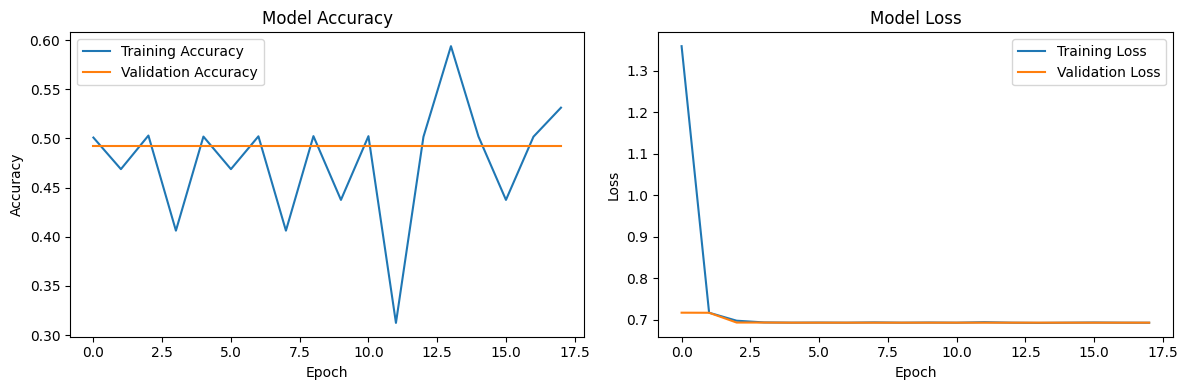

In [11]:
# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)



Processing image: C39P4thinF_original_IMG_20150622_105803_cell_112.png


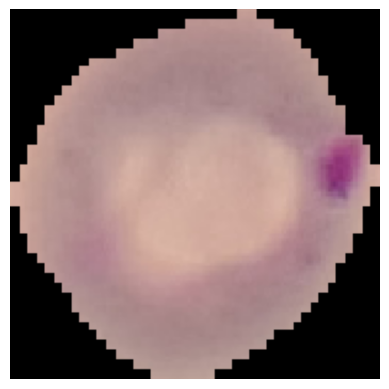

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_25.png


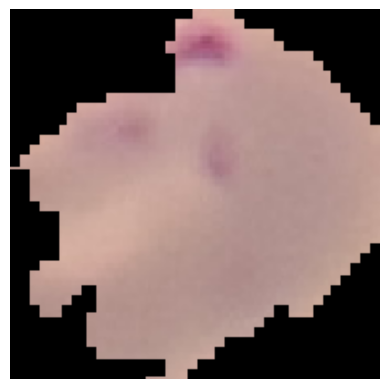

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_81.png


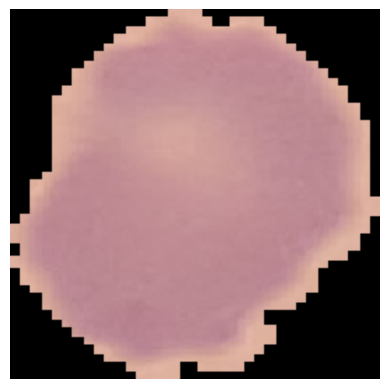

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_86.png


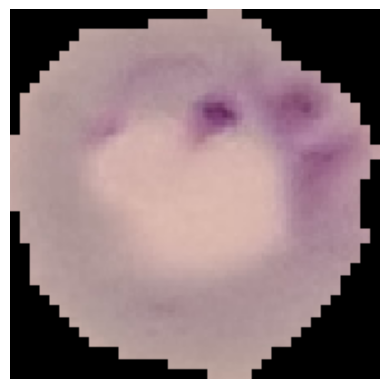

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_44.png


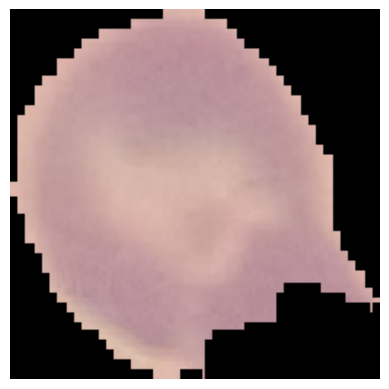

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_166.png


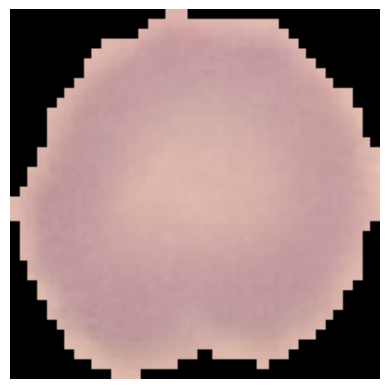

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_109.png


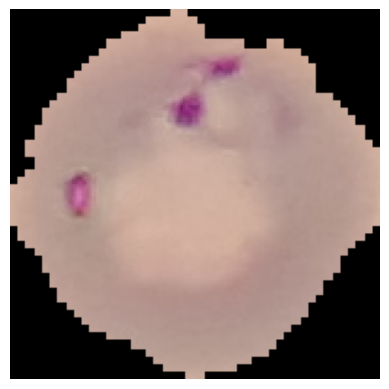

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
infected

Processing image: C3thin_original_IMG_20150608_162922_cell_145.png


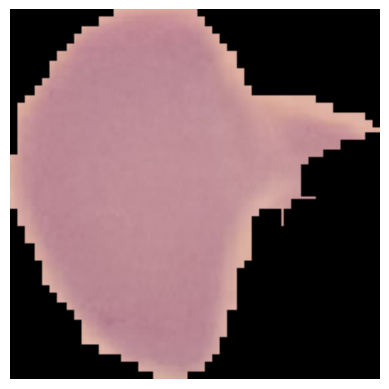

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_112.png


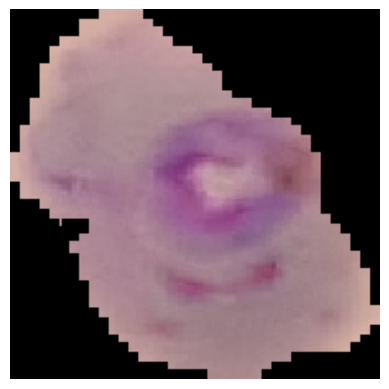

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
infected

Processing image: C3thin_original_IMG_20150608_163047_cell_145.png


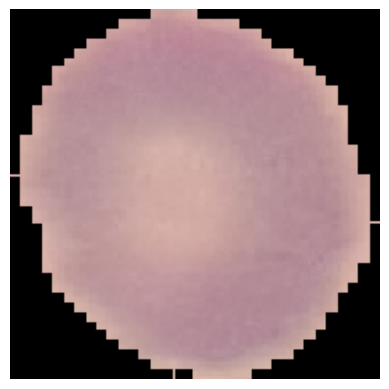

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_118.png


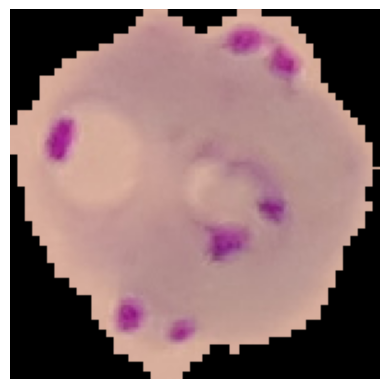

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_19.png


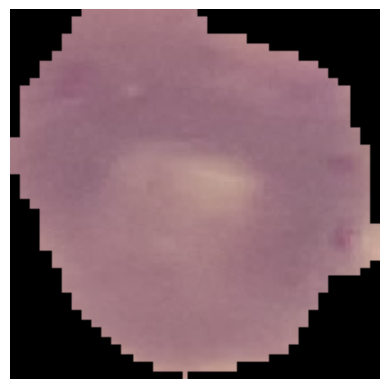

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
infected

Processing image: C3thin_original_IMG_20150608_163047_cell_161.png


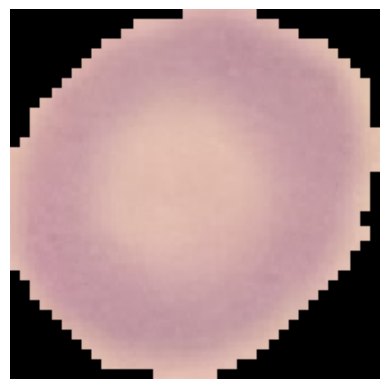

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_26.png


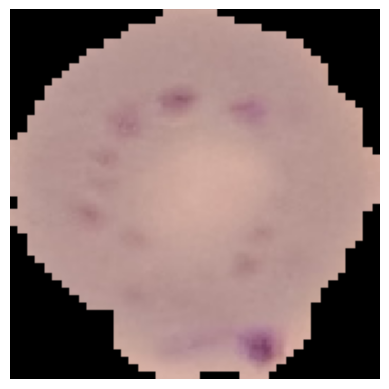

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
infected

Processing image: C3thin_original_IMG_20150608_163047_cell_183.png


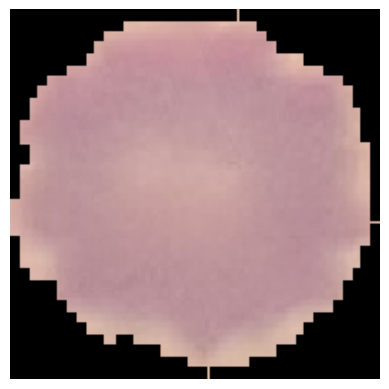

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_115.png


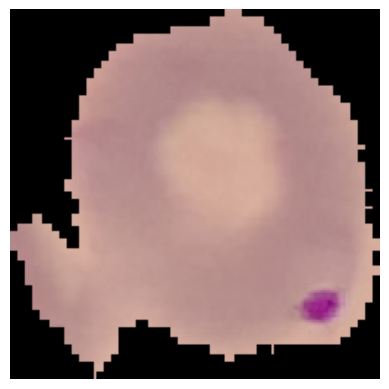

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_130.png


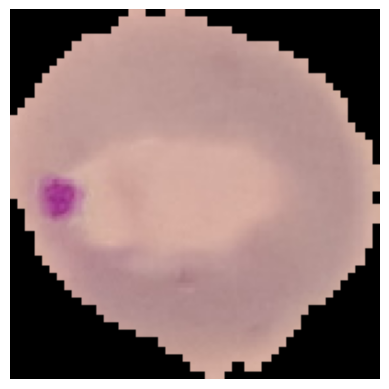

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_109.png


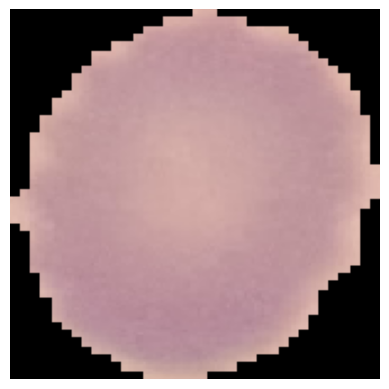

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_97.png


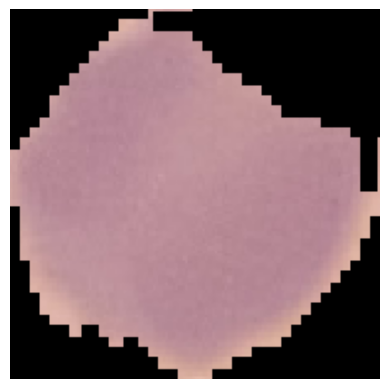

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_85.png


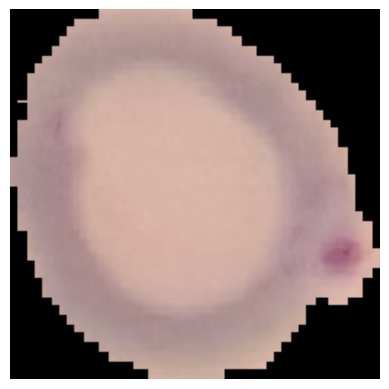

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_106.png


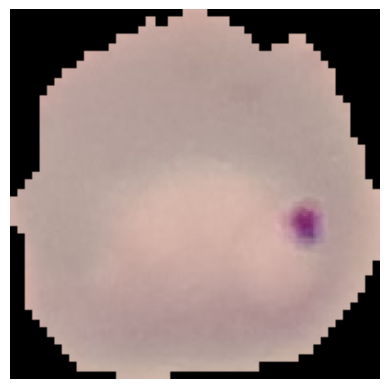

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_103.png


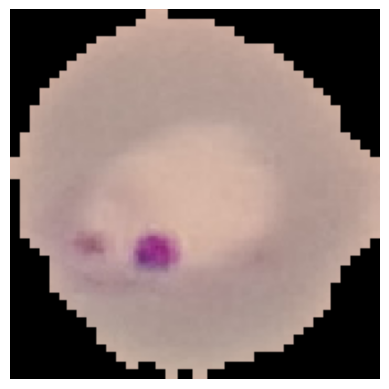

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_80.png


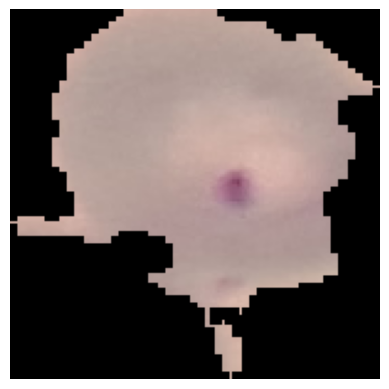

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_125.png


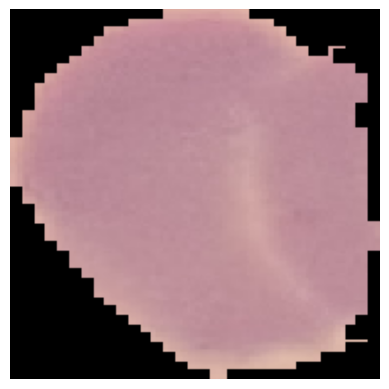

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_13.png


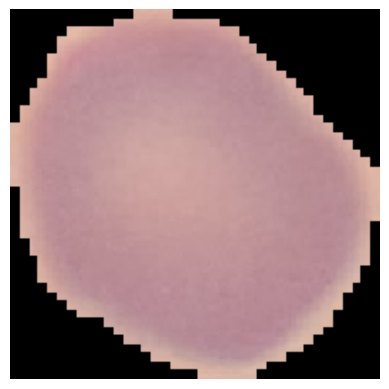

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
uninfected

Processing image: C3thin_original_IMG_20150608_163047_cell_168.png


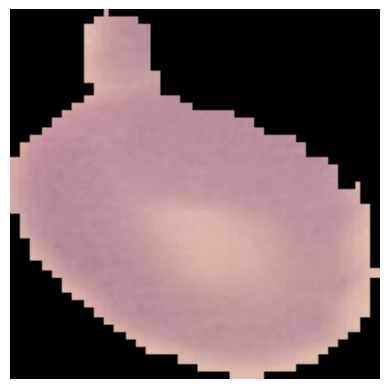

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
infected

Processing image: C3thin_original_IMG_20150608_163047_cell_26.png


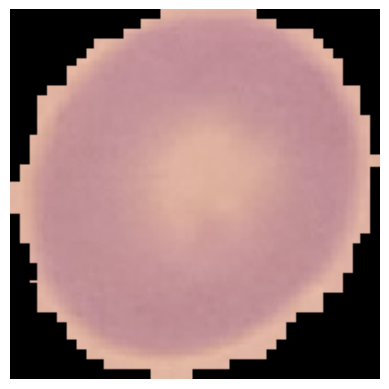

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_90.png


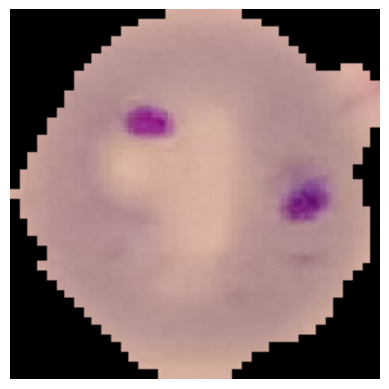

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
infected

Processing image: C3thin_original_IMG_20150608_163047_cell_36.png


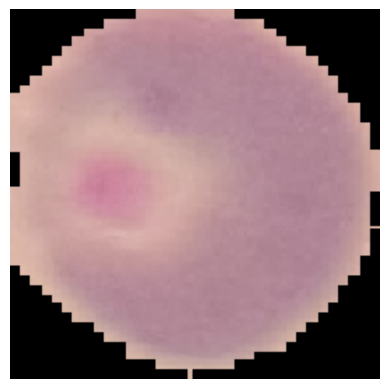

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_9.png


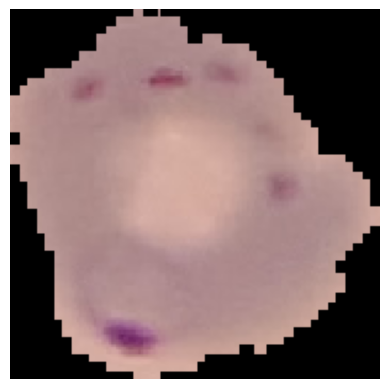

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_111.png


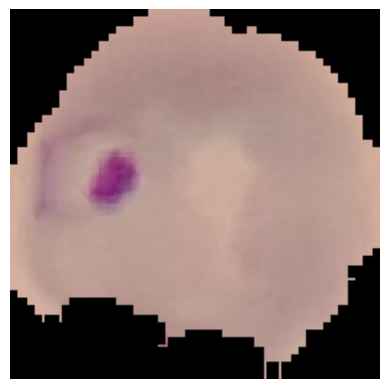

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_15.png


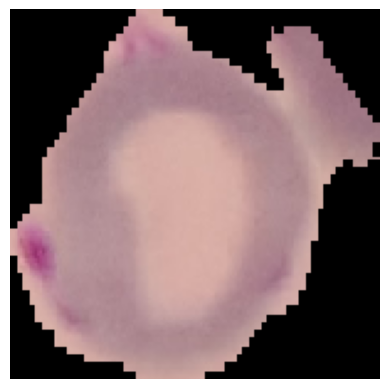

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_93.png


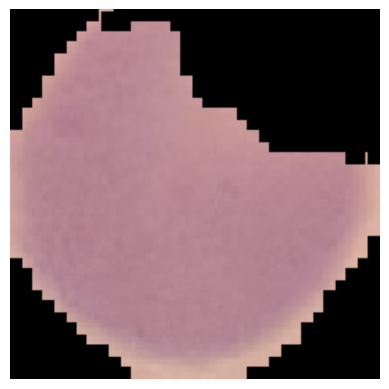

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_21.png


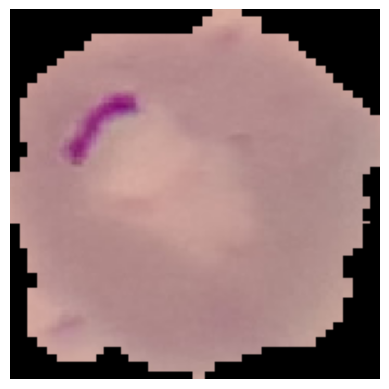

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_57.png


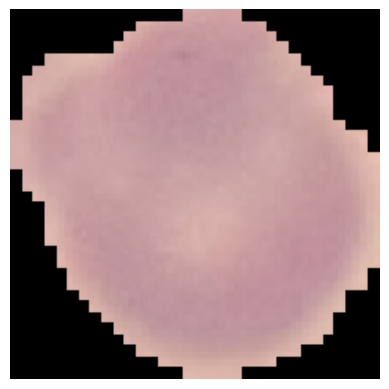

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_24.png


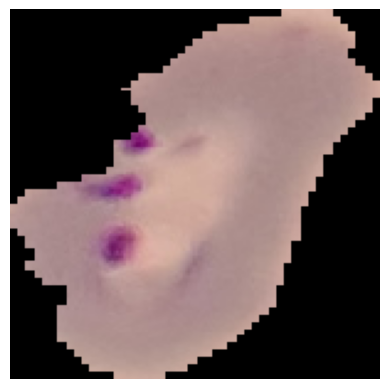

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_138.png


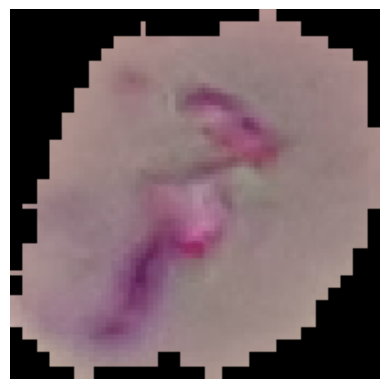

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_99.png


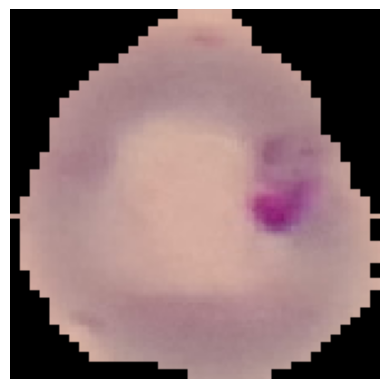

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_108.png


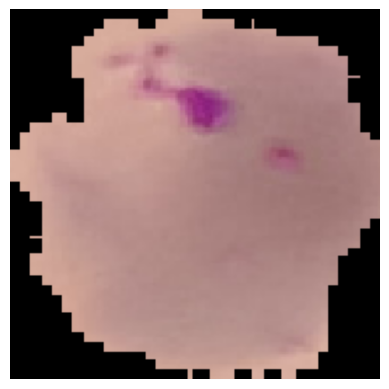

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_81.png


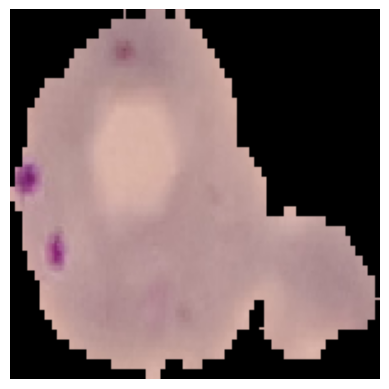

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_20.png


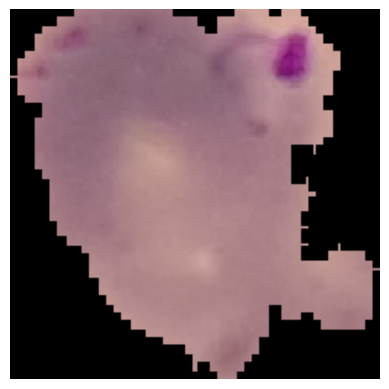

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_220.png


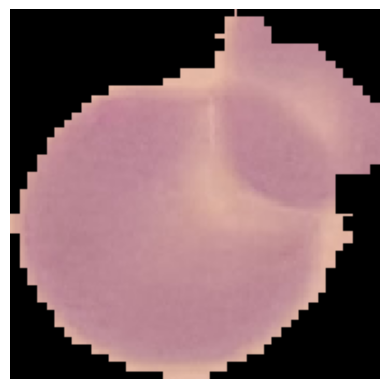

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_78.png


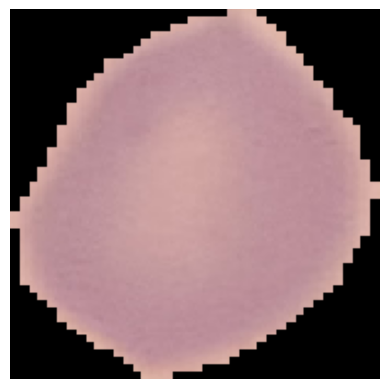

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_97.png


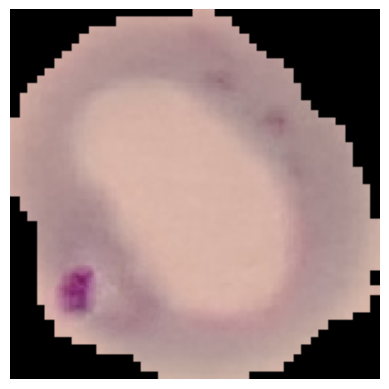

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_78.png


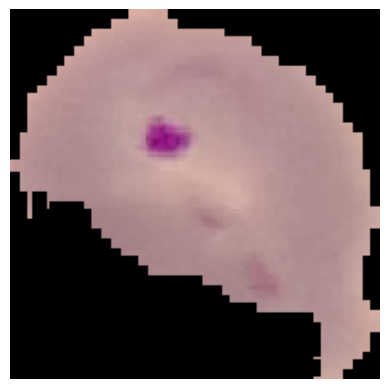

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_63.png


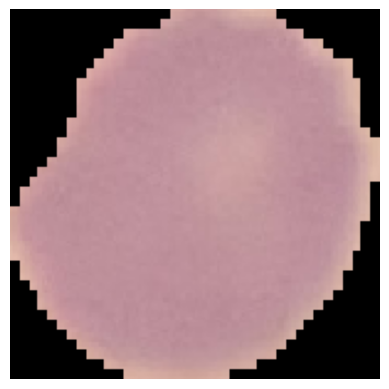

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_22.png


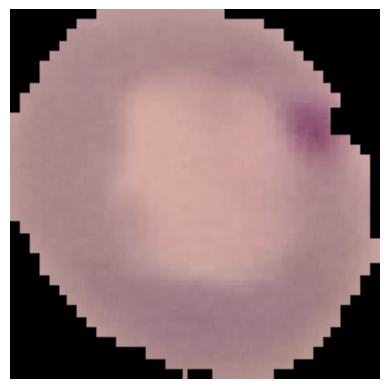

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_125.png


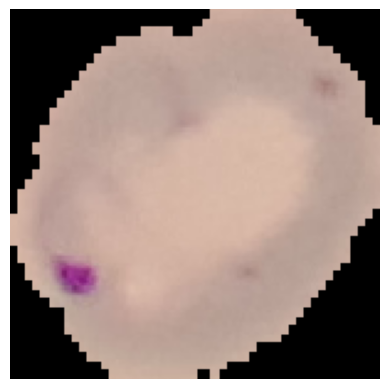

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_111.png


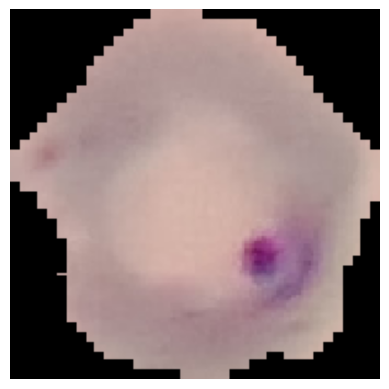

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_116.png


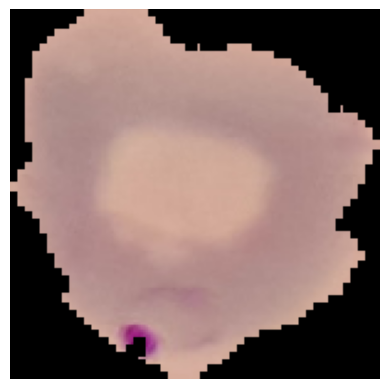

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_95.png


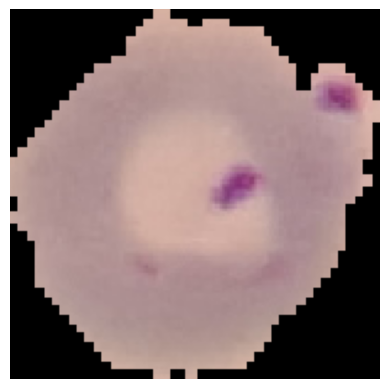

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110352_cell_79.png


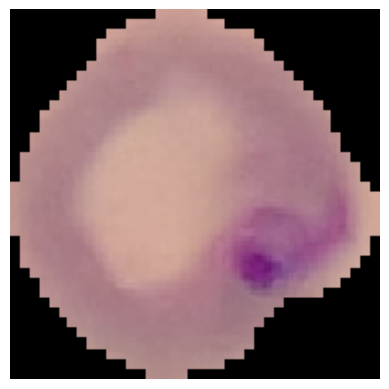

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_126.png


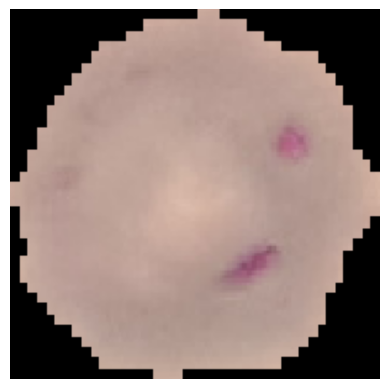

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_134.png


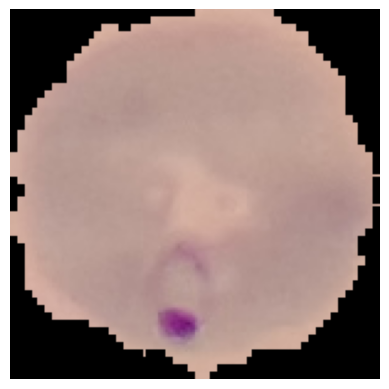

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_119.png


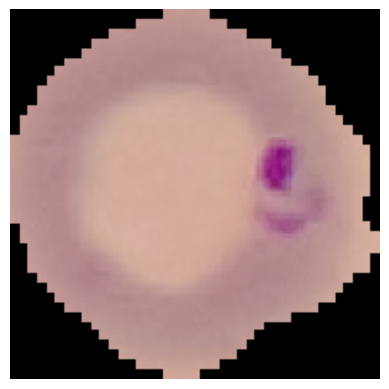

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_10.png


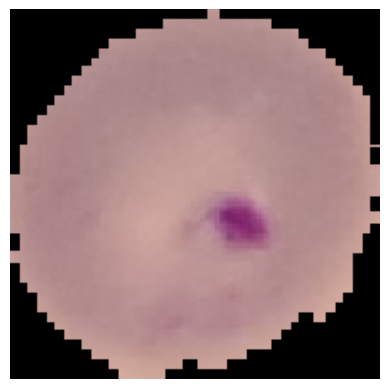

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_156.png


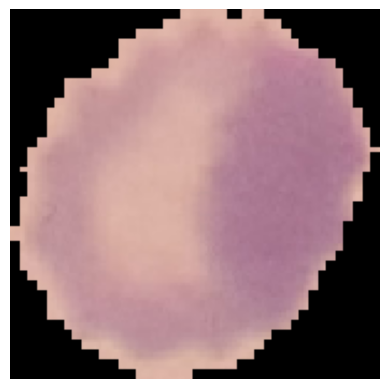

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_133.png


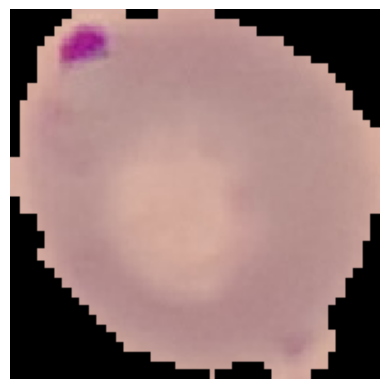

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
infected

Processing image: C3thin_original_IMG_20150608_162922_cell_217.png


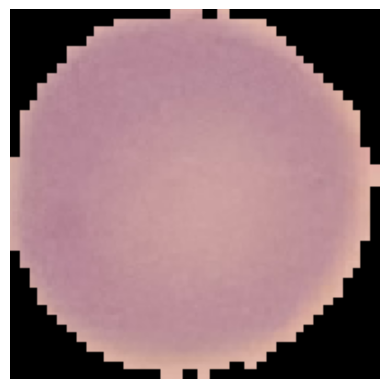

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_91.png


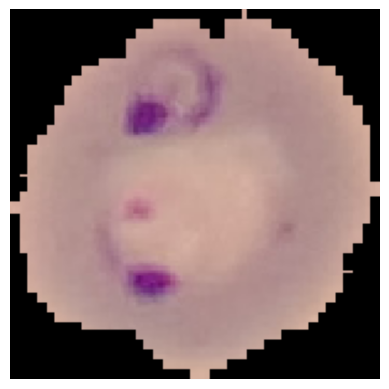

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_195.png


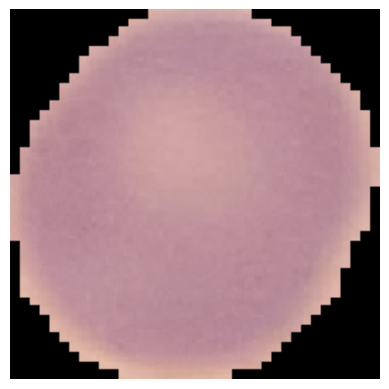

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_110.png


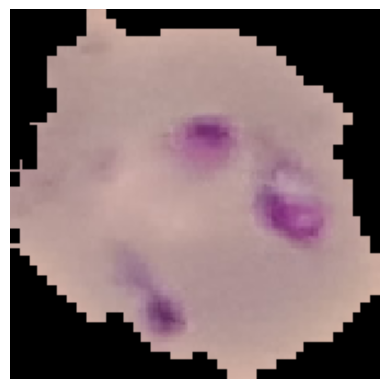

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_117.png


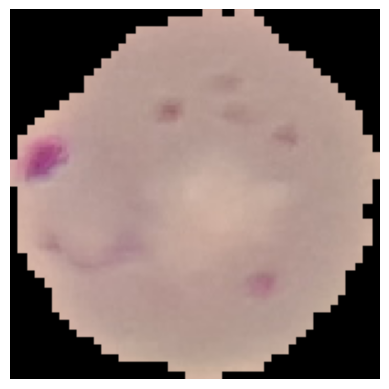

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_34.png


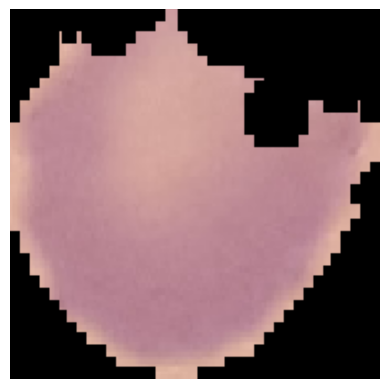

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
infected

Processing image: C3thin_original_IMG_20150608_162922_cell_191.png


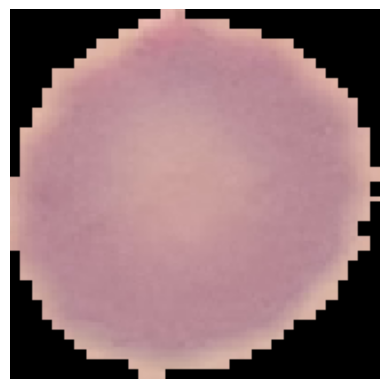

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_16.png


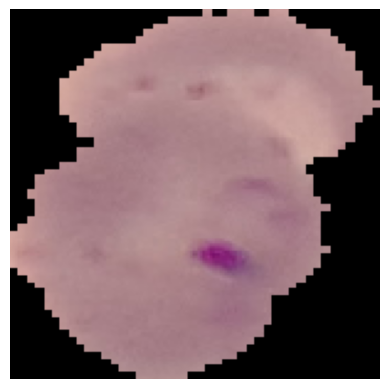

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_121.png


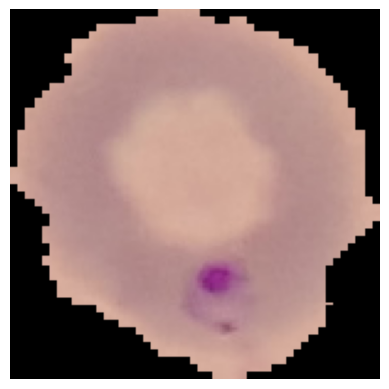

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_105.png


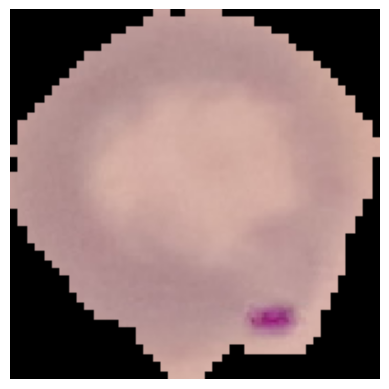

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_202.png


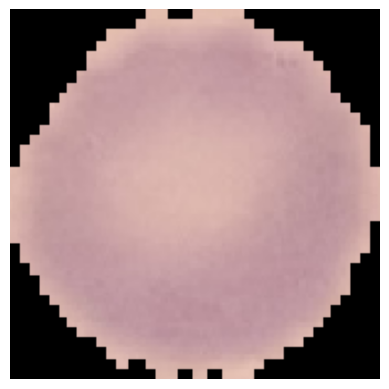

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_83.png


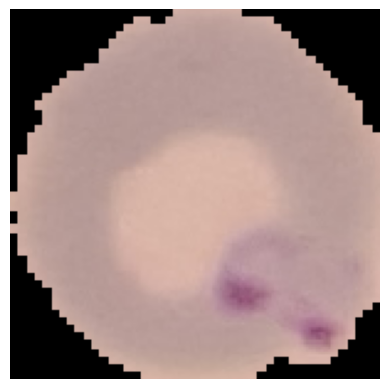

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_104.png


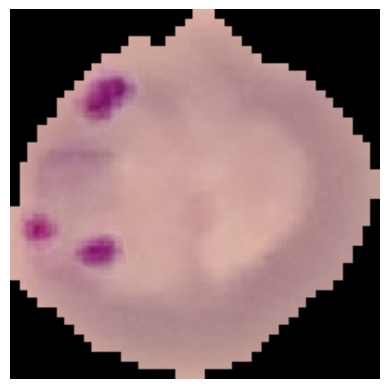

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110352_cell_80.png


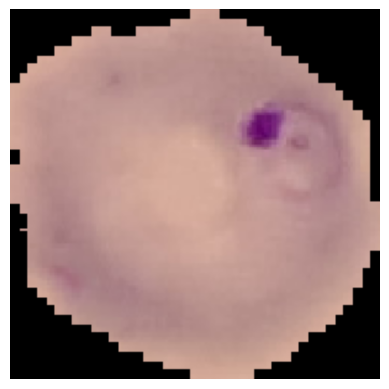

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_122.png


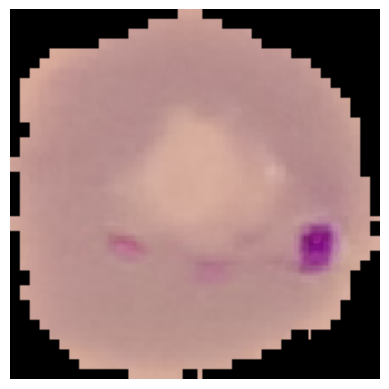

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_17.png


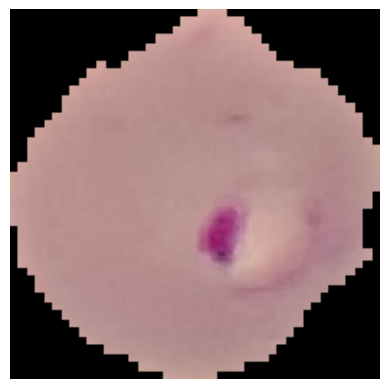

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_87.png


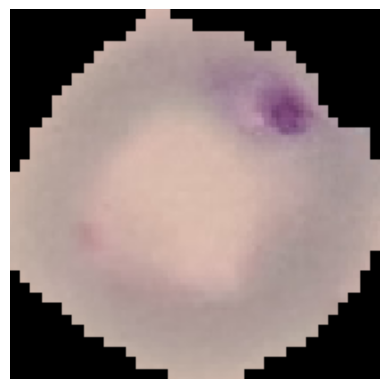

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_146.png


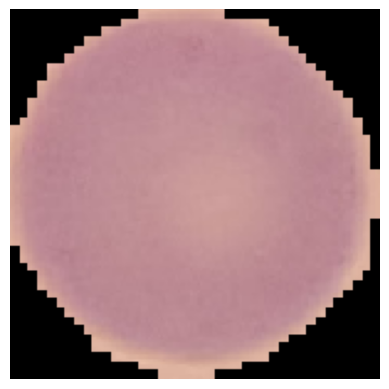

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_129.png


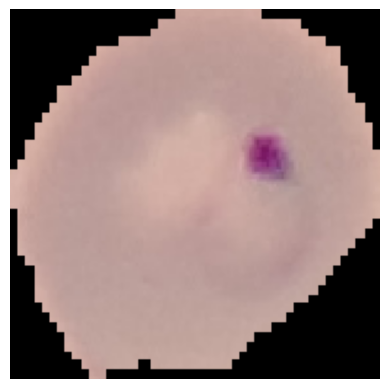

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_80.png


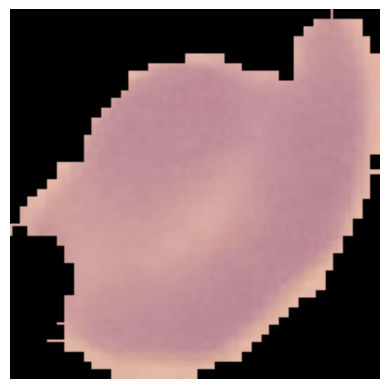

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_88.png


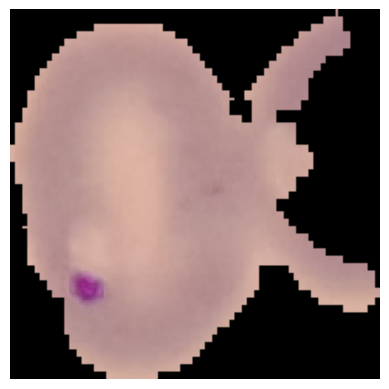

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_186.png


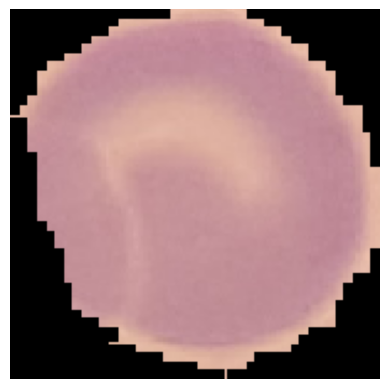

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_92.png


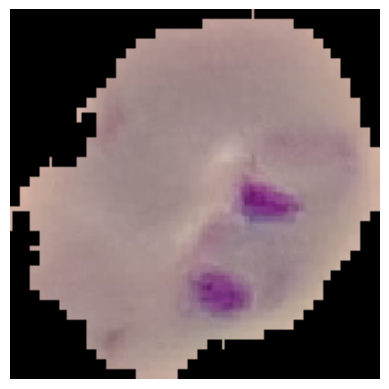

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_136.png


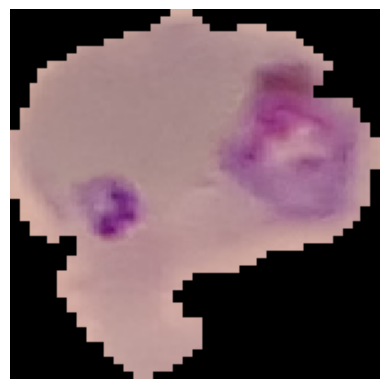

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_32.png


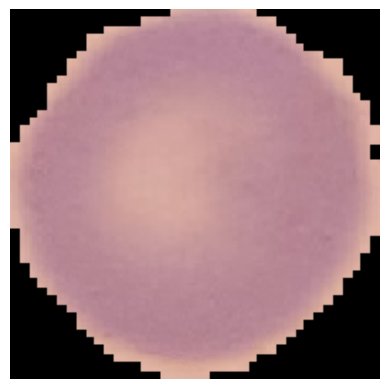

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_101.png


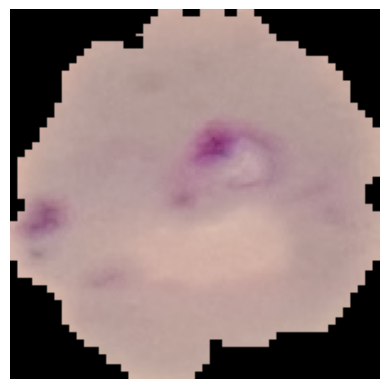

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_102.png


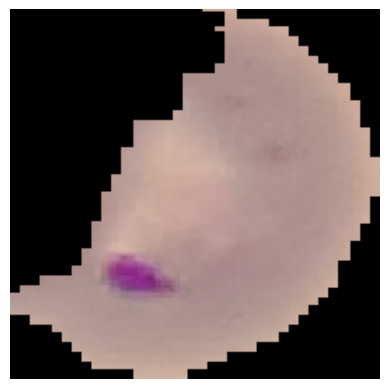

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_127.png


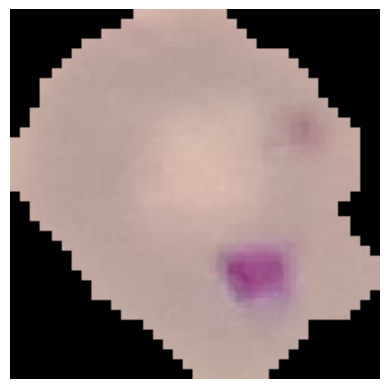

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_135.png


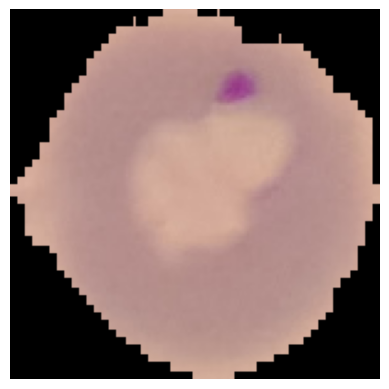

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_96.png


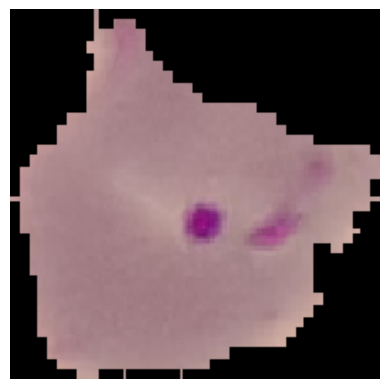

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_11.png


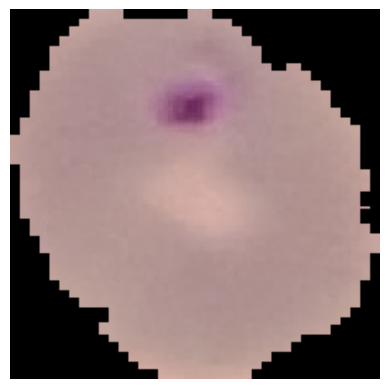

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_23.png


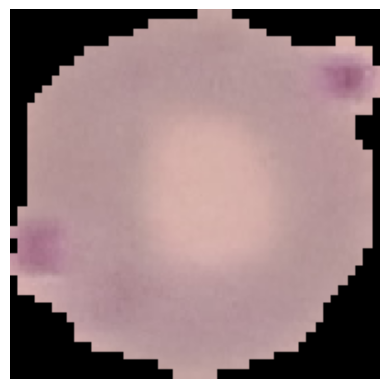

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_79.png


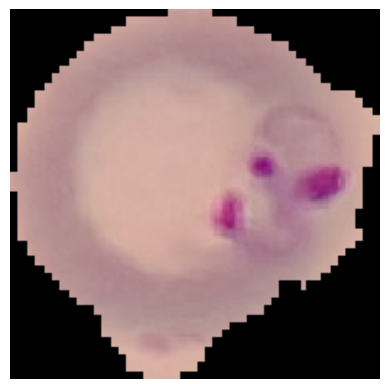

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_89.png


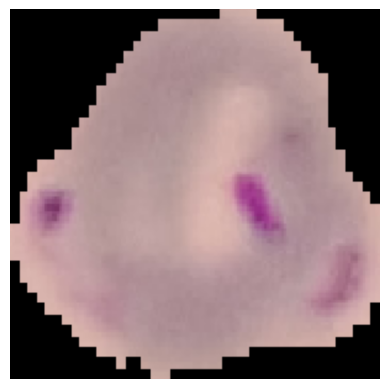

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
infected

Processing image: C3thin_original_IMG_20150608_163047_cell_147.png


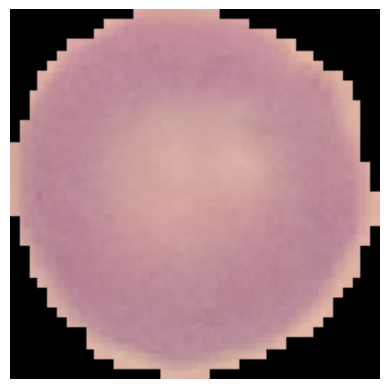

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_13.png


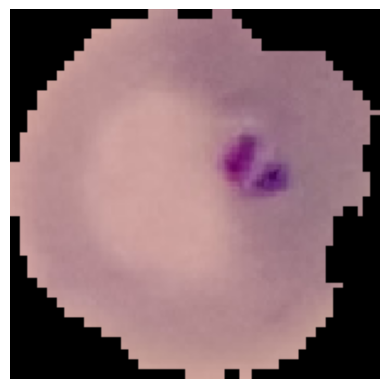

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
infected

Processing image: C3thin_original_IMG_20150608_163002_cell_159.png


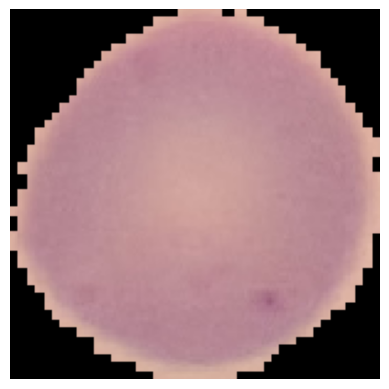

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_107.png


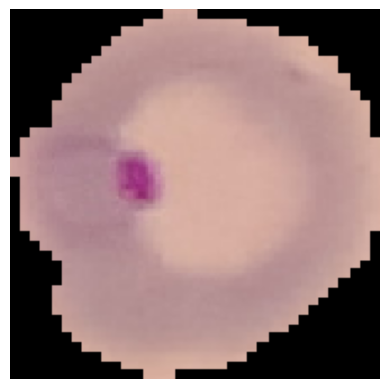

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_124.png


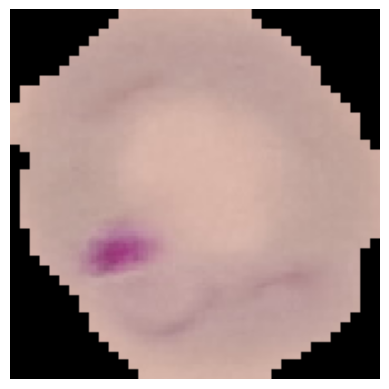

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_98.png


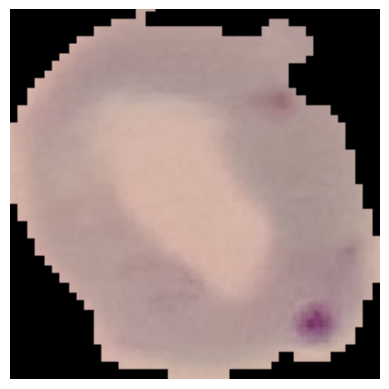

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
infected

Processing image: C3thin_original_IMG_20150608_163029_cell_1.png


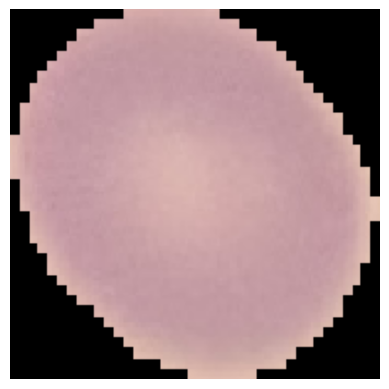

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_18.png


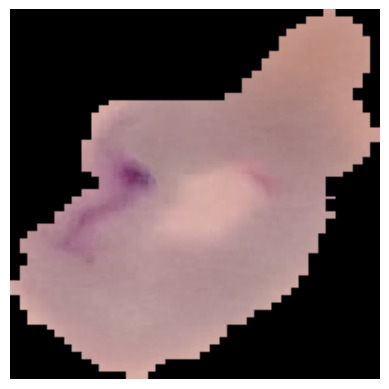

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
infected

Summary of Results:
Image: C39P4thinF_original_IMG_20150622_105803_cell_112.png, Probability of being uninfected: 0.0000
Image: C39P4thinF_original_IMG_20150622_105554_cell_25.png, Probability of being uninfected: 0.0000
Image: C3thin_original_IMG_20150608_163002_cell_81.png, Probability of being uninfected: 1.0000
Image: C39P4thinF_original_IMG_20150622_105803_cell_86.png, Probability of being uninfected: 0.0000
Image: C3thin_original_IMG_20150608_163029_cell_44.png, Probability of being uninfected: 1.0000
Image: C3thin_original_IMG_20150608_163029_cell_166.png, Probability of being uninfected: 1.0000
Image: C39P4thinF_original_IMG_20150622_110115_cell_109.png, Probability of being uninfected: 0.0000
Image: C3thin_original_IMG_20150608_162922_cell_145.png, Probability of being uninfected: 0.0000
Image: C39P4thinF_original_IMG_20150622_110115_cell_112.png, Probability of being uninfected: 0.0000
Image: C3thin_original_IMG_20150608_163047

In [14]:

# Path to your test directory
dir_path = r'C:\Users\OMEN\Malaria_Project\notebook\data\Test'

# Function to predict and display results
def predict_and_display(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    val = model.predict(images)

    if val[0][0] > 0.5:  # Assuming 0.5 as the threshold
        print("uninfected")
    else:
        print("infected")

    return val[0][0]

# Get list of all images and randomly select 50
all_images = os.listdir(dir_path)
selected_images = random.sample(all_images, min(100, len(all_images)))

# Process 50 randomly selected images
results = []
for i in selected_images:
    img_path = os.path.join(dir_path, i)
    print(f"\nProcessing image: {i}")
    probability = predict_and_display(model, img_path)
    results.append({'image': i, 'probability': probability})

# Display summary of results
print("\nSummary of Results:")
for result in results:
    print(f"Image: {result['image']}, Probability of being uninfected: {result['probability']:.4f}")

# Calculate overall statistics
infected_count = sum(1 for result in results if result['probability'] <= 0.5)
uninfected_count = len(results) - infected_count

print(f"\nTotal images processed: {len(results)}")
print(f"Classified as infected: {infected_count}")
print(f"Classified as uninfected: {uninfected_count}")
print(f"Accuracy on this set: {infected_count/len(results):.2%}")  # Assuming all images in this directory are actually infected